# Linear Regression: Gaussian Regression

- Looking for the posterior mean and std

In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
import jax.random as random
import jax.numpy as jnp
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
#sns.set_style("darkgrid");
plt.rcParams['figure.dpi'] = 100
# plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
# plt.style.use("dark_background")

In [2]:
def medstat(v):
    v = v.sort()
    med = v[len(v)//2]
    mad = np.median(np.abs(v-med))
    mad_sd = 1.483 * mad
    return med, mad_sd

def print_abs_summary(d, keys=None):
    print(' Med MAD_SD')
    for k, v in d.items():
        if (keys is None) or (k in keys):
            med, mad_sd = medstat(v)
            print(f'{k:7} {med:+5.3f} {mad_sd:+5.3f}')

In [3]:
rngkey = random.PRNGKey(0)
rngkey, subkey = jax.random.split(rngkey)
rngkey

array([4146024105,  967050713], dtype=uint32)

## MCMC Inference

In [4]:
def mcmcinf(model, args):
    # args: dict for model input arguments
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=1)
    #
    mcmc.run(rngkey, **args)
    mcmc.print_summary(exclude_deterministic=True, prob=.8)
    return mcmc

# Heights of daughter an mother

In [5]:
df = pd.read_csv('ROS-Examples/PearsonLee/data/Heights.txt', delimiter=' ')
df

,daughter_height,mother_height
0,52.5,59.5
1,52.5,59.5
2,53.5,59.5
3,53.5,59.5
4,55.5,59.5
...,...,...
5519,71.5,70.5
5520,73.5,63.5
5521,73.5,63.5
5522,73.5,63.5


<AxesSubplot:xlabel='mother_height', ylabel='daughter_height'>

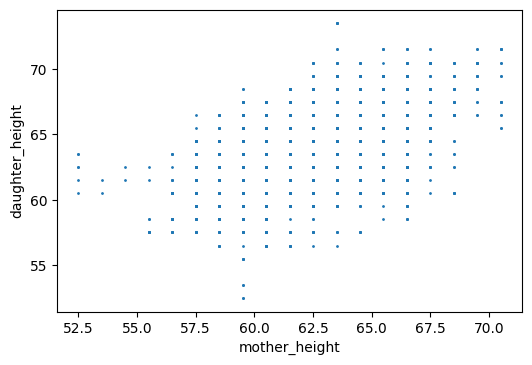

In [6]:
df.plot(kind='scatter', x='mother_height', y='daughter_height', s=1)

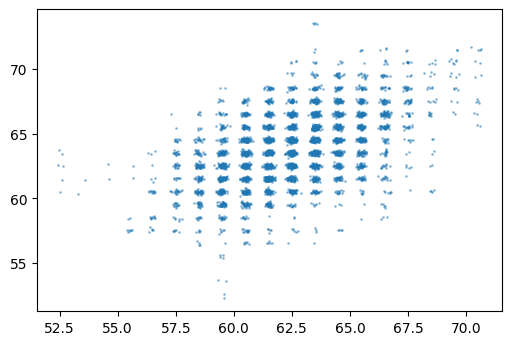

In [7]:
# jitter to display all the data points
n = len(df)
plt.scatter(df.mother_height + np.random.randn(n)*.1, 
            df.daughter_height + np.random.randn(n)*.1,
            s=1, alpha=.4)

# Simple Gaussian Model

$$
    y_i = a + b x_i + \epsilon_i \quad \epsilon_i \sim \mathrm{Normal}(0, \sigma) \\
    y_i \sim \mathrm{Normal}(a + b x_i, \sigma)  \quad\mbox{observation model}
$$

## Prior Models & MCMC

$$
    a \sim \mathrm{Normal}(\mu_a, \sigma_a) \\
    b \sim \mathrm{Normal}(\mu_b, \sigma_b)
$$

In [8]:
def model(x, y=None, mua=0., stda=1., mub=0., stdb=1., sgscale=10.):
    a = numpyro.sample('a', dist.Normal(mua, stda))
    b = numpyro.sample('b', dist.Normal(mub, stdb))
    
    mu = a + b * x
    
    sigma = numpyro.sample('sigma', dist.HalfNormal(sgscale))  # observation uncertainty
    
    with numpyro.plate(f'y:{len(x)}', size=len(x)):
        yobs = numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

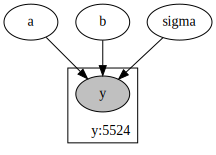

In [9]:
numpyro.render_model(model, model_args=(df.mother_height.values, df.daughter_height.values))

In [10]:
args = dict(x=df.mother_height.values, 
            y=df.daughter_height.values)
mcmc = mcmcinf(model, args)

sample: 100%|██████████| 11000/11000 [00:31<00:00, 346.50it/s, 127 steps of size 4.09e-02. acc. prob=0.92]



                mean       std    median     10.0%     90.0%     n_eff     r_hat
         a     18.06      0.65     18.07     17.22     18.88   2557.52      1.00
         b      0.73      0.01      0.73      0.72      0.75   2565.49      1.00
     sigma      2.31      0.02      2.31      2.28      2.34   3374.20      1.00

Number of divergences: 0


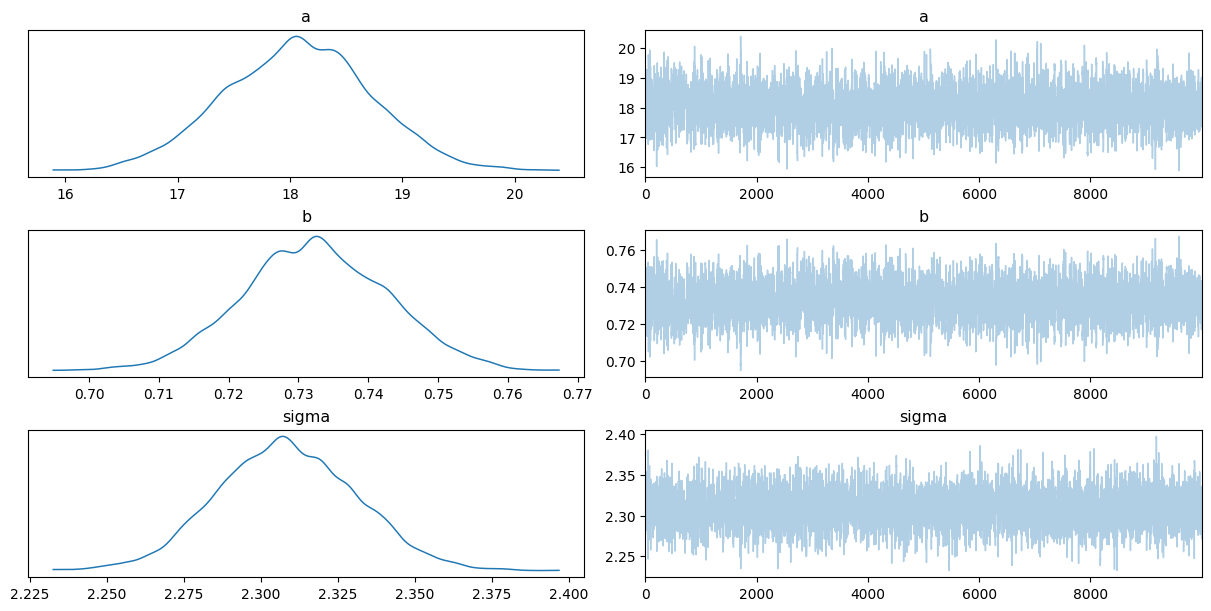

In [11]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata);

18.063429 0.7324157 2.308331


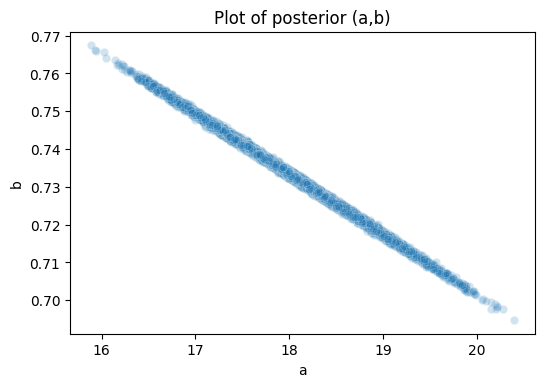

In [12]:
samples = mcmc.get_samples()
am, bm, sm = [s.mean() for k, s in samples.items()]
print(am, bm, sm)

ax = sns.scatterplot(x=samples['a'], y=samples['b'], alpha=.2)
ax.set(xlabel='a', ylabel='b', title='Plot of posterior (a,b)');

- Bias and slop are correlated, very much.
    - Pearson's correlation coefficient will be almost 1 or -1.
- Any change in 'a' causes change in 'b'.
- This may be a trouble maker in numerical computation.

In [13]:
np.corrcoef(x=samples['a'], y=samples['b'])[0,1]

-0.9988477676631617

## Posterior Mean

In [14]:
samples = mcmc.get_samples()
am, bm, sm = [s.mean() for k, s in samples.items()]
print(am, bm, sm)

18.063429 0.7324157 2.308331


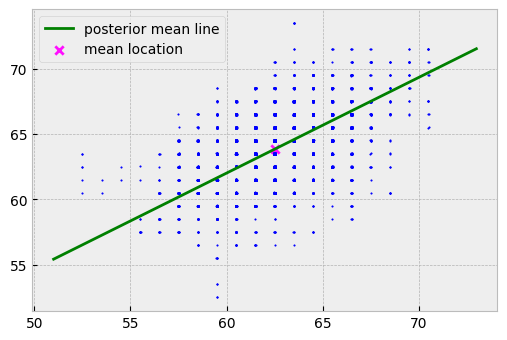

In [15]:
with plt.style.context('bmh'):
    x = np.linspace(51, 73, 100)  # prediction points

    plt.scatter(x=df.mother_height.values.mean(), y=df.daughter_height.values.mean(), marker='x', color='#ff0fff',
               label='mean location')

    y = am + bm * x
    plt.plot(x, y, c='g', label='posterior mean line')
    plt.legend()

    # jitter to display all the data points
    n = len(df)
    plt.scatter(df.mother_height + np.random.randn(n)*.01,
                df.daughter_height + np.random.randn(n)*.01,
                s=1, alpha=.94, c='b')
    #

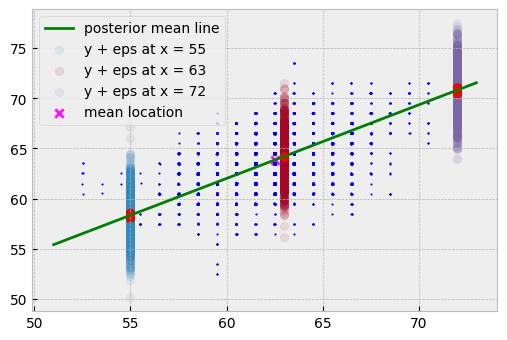

In [16]:
with plt.style.context('bmh'):
    x = np.linspace(51, 73, 100)  # prediction points

    xs = [55, 63, 72]
    yss, yss, yerrss = [], [], []
    for x0 in xs:
        y0s, yerrs = [], []
        for i, (a, b, sg) in enumerate(zip(samples['a'], samples['b'], samples['sigma'])):
            y = a  +  b * x0 
            yerrs.append( np.random.randn() * sg )
            y0s.append(y)
            if i > 1000: break
        y0s, yerrs = np.array(y0s), np.array(yerrs)
        plt.scatter([x0]*len(y0s), y0s + yerrs, alpha=.1, label=f'y + eps at x = {x0}')
        plt.scatter([x0]*len(y0s), y0s, alpha=.1, color='r')
        yss.append(y0s), yerrss.append(yerrs)
    yss = np.array(yss)
    #
    plt.scatter(x=df.mother_height.values.mean(), y=df.daughter_height.values.mean(), 
                marker='x', color='#ff0fff', label='mean location')
    #
    y = am + bm * x
    plt.plot(x, y, c='g', label='posterior mean line')
    plt.legend()

    # jitter to display all the data points
    n = len(df)
    plt.scatter(df.mother_height + np.random.randn(n)*.01,
                df.daughter_height + np.random.randn(n)*.01,
                s=1, alpha=.94, c='b', label='data')
    #

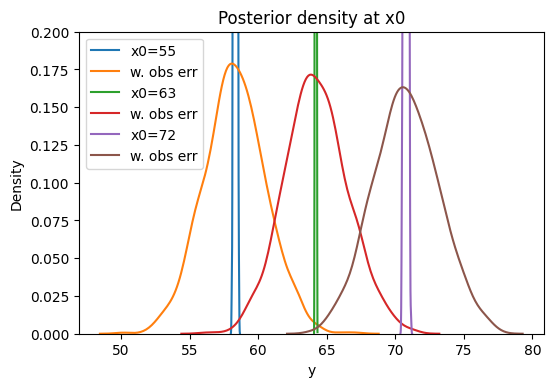

In [17]:
for x0, y0s, yerrs in zip(xs, yss, yerrss):
    ax = sns.kdeplot(y0s, label=f'x0={x0}');
    ax = sns.kdeplot(y0s+yerrs, label='w. obs err')
ax.set(title='Posterior density at x0', xlabel='y', ylim=[0, .2]);
ax.legend();

y:  (100, 1300) (100,)


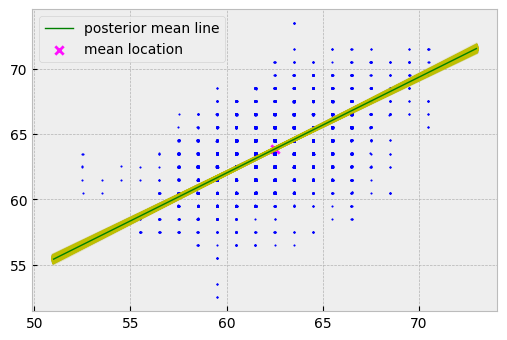

In [18]:
with plt.style.context('bmh'):
    x = np.linspace(51, 73, 100)  # prediction points

    n = 1300
    y = samples['a'][:n]  +  samples['b'][:n] * x.reshape(-1,1)
    print('y: ', y.shape, x.shape)
    plt.plot(x, y, alpha=.1, c='y')

    #
    plt.scatter(x=df.mother_height.values.mean(), y=df.daughter_height.values.mean(), 
                marker='x', color='#ff0fff', label='mean location')
    #
    y = am + bm * x
    plt.plot(x, y, c='g', label='posterior mean line', linewidth=1)
    plt.legend()

    # jitter to display all the data points
    n = len(df)
    plt.scatter(df.mother_height + np.random.randn(n)*.01,
                df.daughter_height + np.random.randn(n)*.01,
                s=1, alpha=.94, c='b', label='data')
    #

In [19]:
x[::30]

array([51.        , 57.66666667, 64.33333333, 71.        ])

In [20]:
samples['b'][:5]

DeviceArray([0.7282861, 0.7287497, 0.7403258, 0.7201736, 0.7207167], dtype=float32)

In [21]:
samples['a'][:5].reshape(-1,1) + samples['b'][:5].reshape(-1, 1) * x[::30] + (np.random.randn(5)*samples['sigma'][:5]).reshape(-1,1)

DeviceArray([[51.648335, 56.50358 , 61.358818, 66.21406 ],
             [54.56522 , 59.42355 , 64.28188 , 69.14021 ],
             [53.88322 , 58.81873 , 63.754234, 68.68974 ],
             [54.918568, 59.719723, 64.52088 , 69.32204 ],
             [56.294197, 61.098976, 65.903755, 70.708534]], dtype=float32)

y:  (100, 300) (100, 300) (100,)


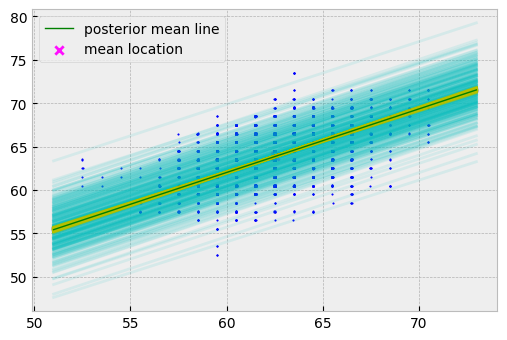

In [22]:
with plt.style.context('bmh'):
    x = np.linspace(51, 73, 100)  # prediction points

    n = 300
    y = samples['a'][:n]  +  samples['b'][:n] * x.reshape(-1, 1)
    y_obs = y + np.random.randn(n)*samples['sigma'][:n]
    print('y: ', y.shape, y_obs.shape, x.shape)
    plt.plot(x, y_obs, alpha=.1, c='c')
    plt.plot(x, y, alpha=.1, c='y')

    #
    plt.scatter(x=df.mother_height.values.mean(), y=df.daughter_height.values.mean(), 
                marker='x', color='#ff0fff', label='mean location')
    #
    y = am + bm * x
    plt.plot(x, y, c='g', label='posterior mean line', linewidth=1)
    plt.legend()

    # jitter to display all the data points
    n = len(df)
    plt.scatter(df.mother_height + np.random.randn(n)*.01,
                df.daughter_height + np.random.randn(n)*.01,
                s=1, alpha=.94, c='b', label='data')
    #

---

## Data Normalization Helps

- Better stability in numerical computation
- remove correlation between bias and slope
- Easier for setting up vague priors

In [23]:
def standardize(data):
    return (data - data.mean()) / data.std()

In [24]:
df['zdaughter'] = standardize(df.daughter_height)
df['zmother'] = standardize(df.mother_height)
df.head(3)

,daughter_height,mother_height,zdaughter,zmother
0,52.5,59.5,-4.342546,-1.244931
1,52.5,59.5,-4.342546,-1.244931
2,53.5,59.5,-3.960154,-1.244931


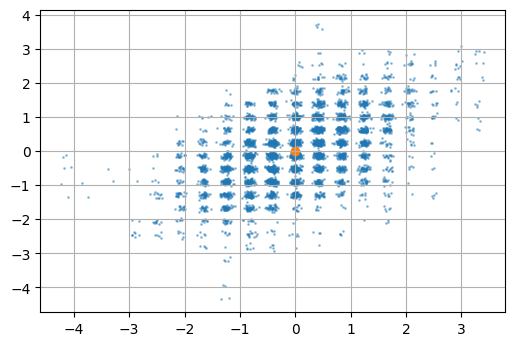

In [25]:
# jitter to display all the data points
n = len(df)
plt.scatter(df.zmother + np.random.randn(n)*.05, 
            df.zdaughter + np.random.randn(n)*.05,
            s=1, alpha=.4)
plt.scatter(df.zmother.mean(), df.zdaughter.mean())
plt.grid(True)

### MCMC Model

In [26]:
def model(x, y=None, mua=0., stda=1., mub=0., stdb=1., sgscale=1.):
    a = numpyro.sample('a', dist.Normal(mua, stda))
    b = numpyro.sample('b', dist.Normal(mub, stdb))
    
    mu = a + b * x
    
    sigma = numpyro.sample('sigma', dist.HalfNormal(sgscale))  # observation uncertainty
    
    with numpyro.plate(f'y:{len(x)}', size=len(x)):
        yobs = numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

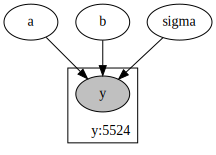

In [27]:
numpyro.render_model(model, model_args=(df.zmother.values, df.zdaughter.values))

In [28]:
args = dict(x=df.zmother.values, 
            y=df.zdaughter.values)
mcmc = mcmcinf(model, args)

sample: 100%|██████████| 11000/11000 [00:13<00:00, 844.74it/s, 3 steps of size 8.72e-01. acc. prob=0.89] 


                mean       std    median     10.0%     90.0%     n_eff     r_hat
         a     -0.00      0.01     -0.00     -0.02      0.01  10648.64      1.00
         b      0.50      0.01      0.50      0.49      0.52  12222.46      1.00
     sigma      0.87      0.01      0.86      0.85      0.87  12090.28      1.00

Number of divergences: 0


- Note that `n_eff` is much larger than before.

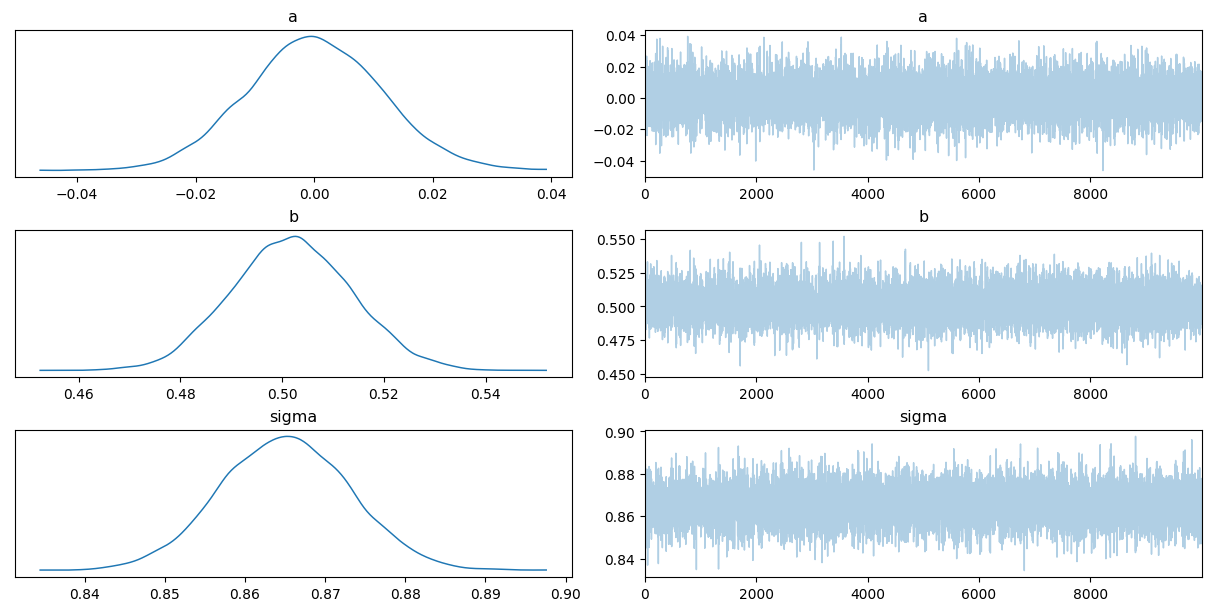

In [29]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata);

-1.5207428e-05 0.5017687 0.8650372


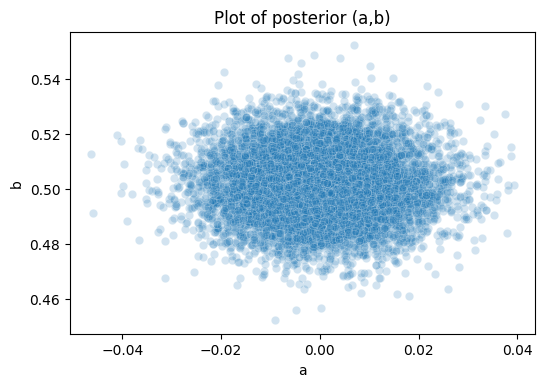

In [30]:
samples = mcmc.get_samples()
am, bm, sm = [s.mean() for k, s in samples.items()]
print(am, bm, sm)

ax = sns.scatterplot(x=samples['a'], y=samples['b'], alpha=.2)
ax.set(xlabel='a', ylabel='b', title='Plot of posterior (a,b)');

In [31]:
# pearson's correlation coefficient
np.corrcoef(x=samples['a'], y=samples['b'])[0,1]

-0.018465193474380102

---

## Data Normalization Helps II

- Better stability in numerical computation
- remove correlation between bias and slope
- Easier for setting up vague priors

In [32]:
def standardize_mean(data):
    return (data - data.mean())

In [33]:
df['mzdaughter'] = standardize_mean(df.daughter_height)
df['mzmother'] = standardize_mean(df.mother_height)
df.head(3)

,daughter_height,mother_height,zdaughter,zmother,mzdaughter,mzmother
0,52.5,59.5,-4.342546,-1.244931,-11.356264,-2.998733
1,52.5,59.5,-4.342546,-1.244931,-11.356264,-2.998733
2,53.5,59.5,-3.960154,-1.244931,-10.356264,-2.998733


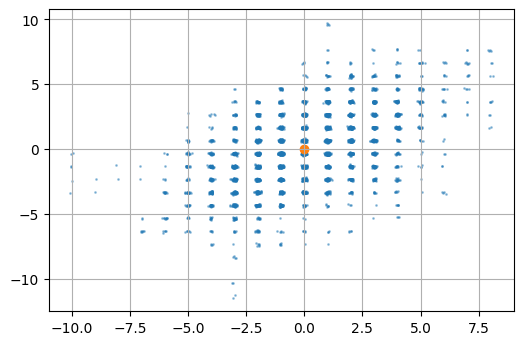

In [34]:
# jitter to display all the data points
n = len(df)
plt.scatter(df.mzmother + np.random.randn(n)*.05, 
            df.mzdaughter + np.random.randn(n)*.05,
            s=1, alpha=.4)
plt.scatter(df.mzmother.mean(), df.mzdaughter.mean())
plt.grid(True)

### MCMC Model

In [35]:
def model(x, y=None, mua=0., stda=1., mub=0., stdb=1., sgscale=1.):
    a = numpyro.sample('a', dist.Normal(mua, stda))
    b = numpyro.sample('b', dist.Normal(mub, stdb))
    
    mu = a + b * x
    
    sigma = numpyro.sample('sigma', dist.HalfNormal(sgscale))  # observation uncertainty
    
    with numpyro.plate(f'y:{len(x)}', size=len(x)):
        yobs = numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

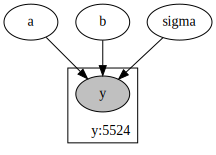

In [36]:
numpyro.render_model(model, model_args=(df.zmother.values, df.zdaughter.values))

In [37]:
args = dict(x=df.mzmother.values, 
            y=df.mzdaughter.values)
mzmcmc = mcmcinf(model, args)

sample: 100%|██████████| 11000/11000 [00:12<00:00, 857.76it/s, 7 steps of size 8.13e-01. acc. prob=0.91] 



                mean       std    median     10.0%     90.0%     n_eff     r_hat
         a      0.00      0.03     -0.00     -0.04      0.04  10368.06      1.00
         b      0.54      0.01      0.54      0.53      0.56   9455.11      1.00
     sigma      2.26      0.02      2.26      2.23      2.29  10395.88      1.00

Number of divergences: 0


- Note that `n_eff` is much larger than before.

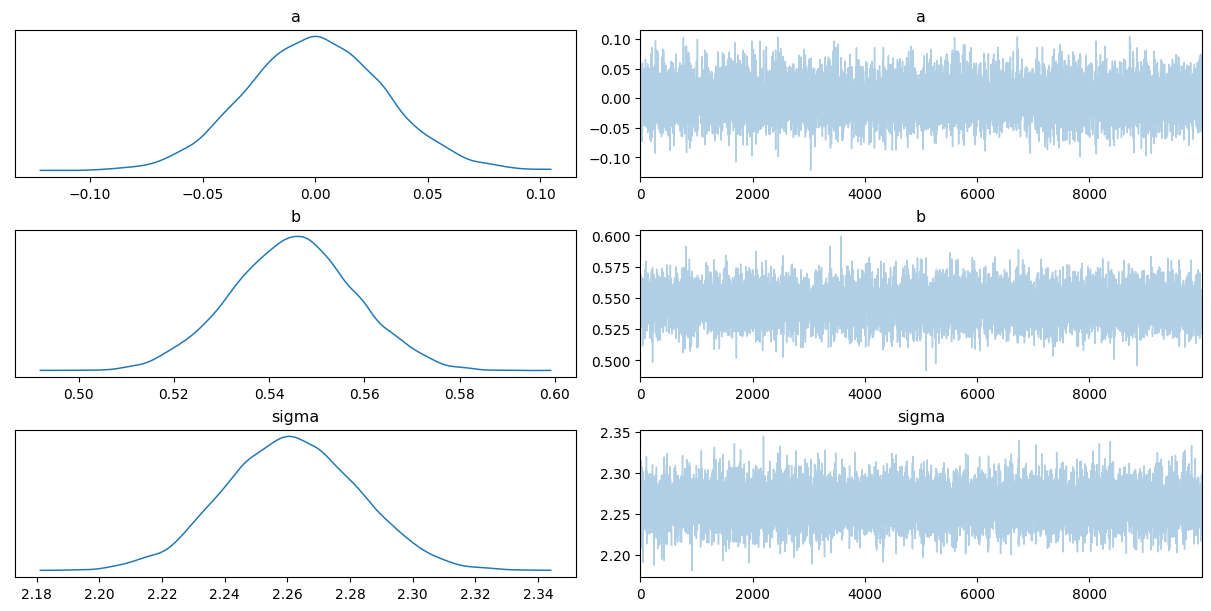

In [38]:
import arviz
azdata = arviz.from_numpyro(mzmcmc)
arviz.plot_trace(azdata);

0.00019544593 0.54492354 2.261245


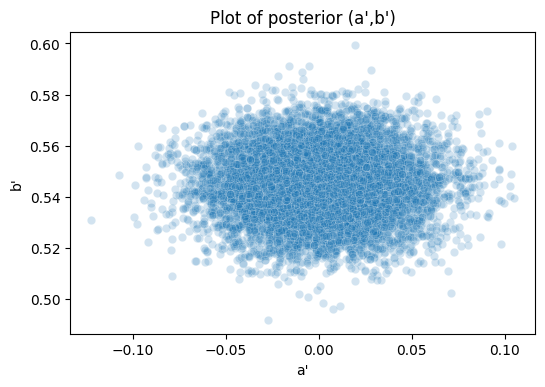

In [46]:
samples = mzmcmc.get_samples()
am, bm, sm = [s.mean() for k, s in samples.items()]
print(am, bm, sm)

ax = sns.scatterplot(x=samples['a'], y=samples['b'], alpha=.2)
ax.set(xlabel='a\'', ylabel='b\'', title='Plot of posterior (a\',b\')');

In [40]:
# pearson's correlation coefficient
np.corrcoef(x=samples['a'], y=samples['b'])[0,1]

-0.0014959572421450302

---

## Conversion back to original scale
$$
    \frac{y - m_y}{s_y} = a' + b' \cdot \frac{x - m_x}{s_x}
$$

$$
    y = a' + \frac{m_y}{s_y} - b' \cdot\frac{m_x}{s_x} + \frac{b'}{s_x} x
$$

\begin{align}
    a &= a' + \frac{m_y}{s_y} - b'\cdot\frac{m_x}{s_x} \\
    b &= \frac{b'}{s_x}
\end{align}

---

# Conclusion

- Read Ch.16. Normal Models in DBDA
- Bayesian Regression for Terrain Ruggedness and GDP
- Bayesian Regression for Divoce Rate Analysis